In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
T = 100
K = 3
D = 2
num_particles_rws = 50
mcmc_steps = 1
num_particles_smc = 50
NUM_HIDDEN = 256
NUM_LATENTS = K*K
NUM_OBS = T * K
# training parameters
NUM_SAMPLES = 1
# BATCH_SIZE = 100
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
CUDA = False

RESTORE = False

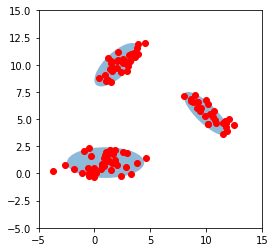

In [3]:
Xs, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
plot_samples(Xs.data.numpy(), mu_true.data.numpy(), cov_true.data.numpy())
Y = Xs

In [4]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, num_particles=1):
        A_samples = torch.zeros((K, num_particles, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden).view(K, K))
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample((num_particles,))
        return latents_dirs, A_samples

In [10]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer

alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0 = pirors(Y, T, D, K)
enc, optimizer = initialize()
## initialization
cov_ks = torch.zeros((K, D, D))
mu_ks = torch.zeros((K, D))
for k in range(K):
## sample mu_k and Sigma_k randomly
    cov_ks[k] = torch.from_numpy(invwishart.rvs(df=nu_0, scale=W_0.data.numpy())).float()
    mu_ks[k] = MultivariateNormal(loc=m_0, covariance_matrix=cov_ks[k] / beta_0).sample()
Pi = Dirichlet(alpha_init_0).sample()
A_samples = initial_trans(alpha_trans_0, K)

In [13]:
KLs = []
KL_ests = []
log_p_conds = []
log_qs = []
ESSs = []

Pi = Pi_true
mu_ks = mu_true
cov_ks = cov_true

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    log_weights_rws = torch.zeros(num_particles_rws)
    log_qs = torch.zeros(num_particles_rws)
    log_p_conds = torch.zeros(num_particles_rws)


    Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
    # draw a sample from the sample set 
    Z_ret = resampling_smc(Zs, log_weights)
    latents_dirs, A_samples_new = enc(Z_ret.contiguous().view(-1, T*K), num_particles_rws)
    loss_inference, kl, kl_est, ess, weights = inclusive_kl(A_samples_new, latents_dirs, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Z_ret, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws)
        
    loss_inference.backward()
    KLs.append(kl.item())
    KL_ests.append(kl_est)
    ESSs.append(ess)
    optimizer.step()
    
    latents_dirs, A_samples = enc(Z_ret.contiguous().view(-1, T*K), 1)
    A_samples = A_samples.squeeze(1).detach()
    print('epoch : %d, KL : %f, kl_est : %f' % (epoch, kl, kl_est))

epoch : 0, KL : 0.972833, kl_est : 0.588047
epoch : 1, KL : 2.256948, kl_est : 0.434638
epoch : 2, KL : 1.862832, kl_est : 0.750553
epoch : 3, KL : 1.133562, kl_est : 1.547113
epoch : 4, KL : 0.894875, kl_est : 1.312494
epoch : 5, KL : 0.689995, kl_est : 0.576012
epoch : 6, KL : 1.014052, kl_est : 0.771887
epoch : 7, KL : 1.120150, kl_est : 0.881173
epoch : 8, KL : 1.081753, kl_est : 0.677008
epoch : 9, KL : 1.035597, kl_est : 0.951089
epoch : 10, KL : 0.925968, kl_est : 0.721508
epoch : 11, KL : 0.665383, kl_est : 0.362668
epoch : 12, KL : 0.749914, kl_est : 0.347009
epoch : 13, KL : 0.434114, kl_est : 0.253015
epoch : 14, KL : 1.069229, kl_est : 1.060937
epoch : 15, KL : 0.400291, kl_est : 0.580419
epoch : 16, KL : 0.779805, kl_est : 0.875006
epoch : 17, KL : 0.251396, kl_est : 0.332758
epoch : 18, KL : 0.841882, kl_est : 1.044935
epoch : 19, KL : 0.994573, kl_est : 0.463391


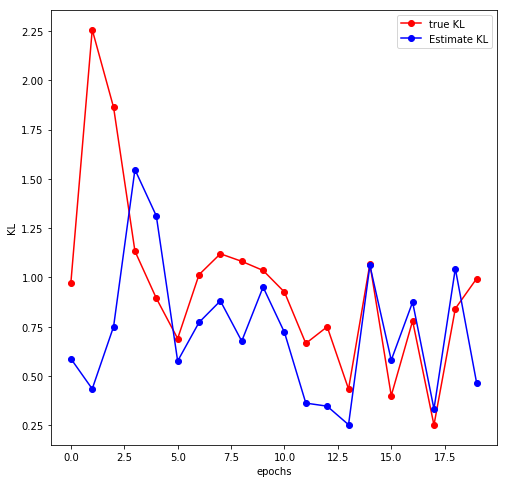

In [14]:
plot_kl_est(np.array(KLs), np.array(KL_ests))

In [15]:
learned_dicichlet_post = latents_dirs
true_dirichlet_post = alpha_trans_0 + pairwise(Z_ret, T).sum(0)
print('variational : ')
print(learned_dicichlet_post)
print('conjugate posterior :')
print(true_dirichlet_post)

variational : 
tensor([[21.3117, 11.4113,  8.8180],
        [ 9.6762, 15.5825,  1.8507],
        [11.5424,  3.1840, 14.7386]], grad_fn=<ExpBackward>)
conjugate posterior :
tensor([[22.3333, 10.3333,  9.3333],
        [11.3333, 17.3333,  3.3333],
        [ 9.3333,  4.3333, 14.3333]])


In [ ]:
plt.plot(np.array(ESSs) / num_particles_rws)

In [ ]:
from torch.distributions.categorical import Categorical
Categorical(torch.Tensor([1/2, 1/2])).sample()

In [ ]:
a = torch.Tensor([1,2,3,4,5])

In [ ]:
a[:-1]